# Skaters (Season 2024/25) - Expected goals

## Step 0: Import libraries

In [4]:
import sys
import os
import pandas as pd

In [5]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
from utils import df_utils, ftab_utils, pmf_utils, cdf_utils, pdf_utils

## Step 1: Import the dataset

In [7]:
#skaters_df = "https://moneypuck.com/moneypuck/playerData/seasonSummary/2024/regular/skaters.csv"
skaters_df = "../data/skaters.csv"
df = pd.read_csv(skaters_df)
df.head(5)

,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,8478047,2024,Michael Bunting,NSH,L,other,76,2237.0,37.0,26.19,...,7.28,10.09,72.0,87.0,0.00,0.00,0.0,0.0,0.0,0.0
1,8478047,2024,Michael Bunting,NSH,L,all,76,70819.0,1474.0,43.70,...,161.54,187.75,3221.0,3522.0,0.00,0.00,0.0,0.0,0.0,0.0
2,8478047,2024,Michael Bunting,NSH,L,5on5,76,59813.0,1294.0,43.70,...,112.73,122.08,2661.0,2707.0,0.71,1.71,19.0,43.0,16.0,31.0
3,8478047,2024,Michael Bunting,NSH,L,4on5,76,6.0,2.0,2.58,...,0.20,0.17,4.0,11.0,0.00,0.00,0.0,0.0,0.0,0.0
4,8478047,2024,Michael Bunting,NSH,L,5on4,76,8763.0,141.0,36.88,...,23.81,2.60,311.0,54.0,0.00,0.01,0.0,1.0,0.0,1.0


## Step 2: Read the data

In [8]:
df_utils.print_df_size(df)

Number of samples: 4600
Number of features: 154


In [9]:
df_utils.save_column_names(df)

Saved: names_columns.txt


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Columns: 154 entries, playerId to fenwickAgainstAfterShifts
dtypes: float64(147), int64(3), object(4)
memory usage: 5.4+ MB


## Step 3: Data cleaning

In [11]:
# Missing values?
df_utils.report_nan(df)

No missing values found.


In [12]:
df = df_utils.drop_duplicate_columns(df, ["faceoffsWon", "I_F_faceOffsWon"])
df = df_utils.drop_duplicate_columns(df, [ "penalityMinutes", "I_F_penalityMinutes"])

Dropped columns: ['I_F_faceOffsWon']
Number of features: 153
Dropped columns: ['I_F_penalityMinutes']
Number of features: 152


## Step 4: Variables and Filter

In [13]:
situation = "all"
feature = "I_F_xGoals"
min_games_played = 20
name_player = "Auston Matthews"

In [14]:
df_goals = df[(df["situation"] == situation) & (df["games_played"] >= min_games_played)]

## Step 5: Summary statistics and Frequency Tables

In [15]:
answer = df[df["situation"] == "all"].loc[lambda d: d[feature].idxmax()]
print(f"Player with the most number of expected goals: {answer["name"]} with {int(answer[feature])} goals.")

answer = df[df["situation"] == "5on4"].loc[lambda d: d['I_F_goals'].idxmax()]
print(f"Player with the most number of expected goals in 5-on-4 situations: {answer["name"]} with {int(answer[feature])} goals.")

answer = df[df["situation"] == "4on5"].loc[lambda d: d['I_F_goals'].idxmax()]
print(f"Player with the most number of expected goals in 4-on-5 situations: {answer["name"]} with {int(answer[feature])} goals.")

Player with the most number of expected goals: Auston Matthews with 41 goals.
Player with the most number of expected goals in 5-on-4 situations: Jake Guentzel with 11 goals.
Player with the most number of expected goals in 4-on-5 situations: Alex Tuch with 2 goals.


Mean: 11.45
Variance: 80.01
Standard deviation: 8.94
Mode: 2.07


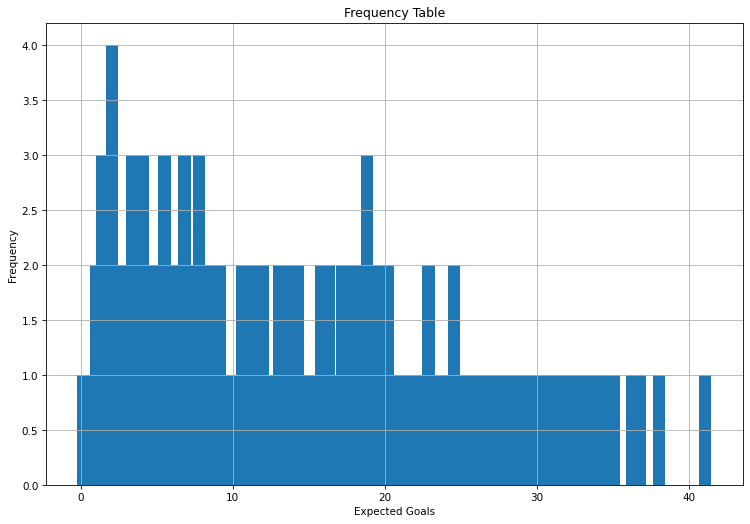

In [16]:
ftab_utils.plot_ftab(df_goals, feature, xlabel="Expected Goals")

## Step 6: Probability Mass Function

Actual PMF: 
Mean: 11.45
Variance: 79.89
Standard deviation: 8.94
Mode: 2.07
Skewness: 0.83

Observed PMF: 
Mean: 18.43
Variance: 83.26
Standard deviation: 9.12
Mode: 18.84
Skewness: 0.09


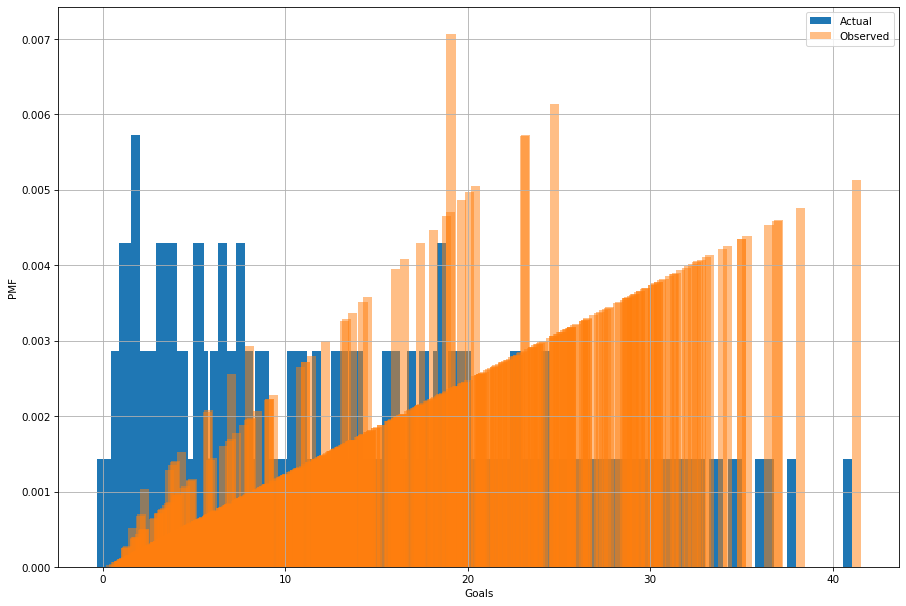

In [17]:
pmf_utils.plot_pmf(df_goals, feature, xlabel="Goals", width=0.5)

## Step 7: Percentile Ranks and Cumulative Distribution Function

Reference player: **Auston Matthews**.

Auston Matthews - Percentile rank: 100.00
Median: 8.77
Interquartile range: 13.58
Quartile skewness: 0.27


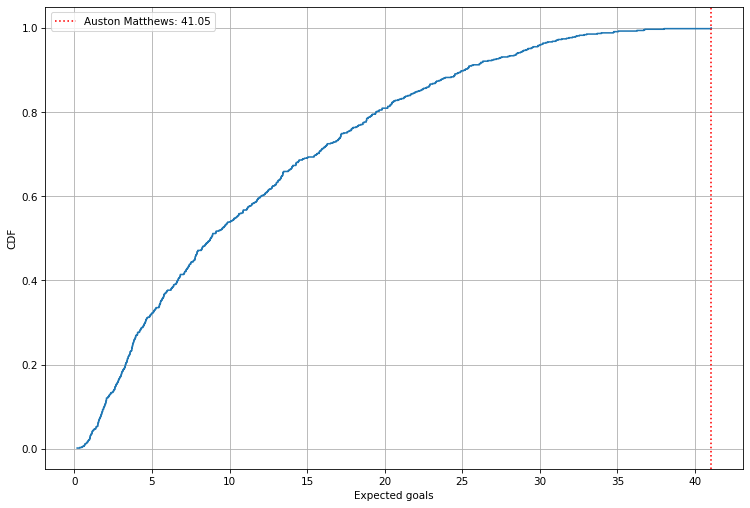

In [18]:
vals = df_goals[feature].values
ref = df_goals[df_goals["name"]==name_player][feature].values[0]

cdf_utils.percentile_rank(ref, vals, label=name_player)
cdf_utils.plot_cdf(ref, vals, label=name_player, xlabel="Expected goals")

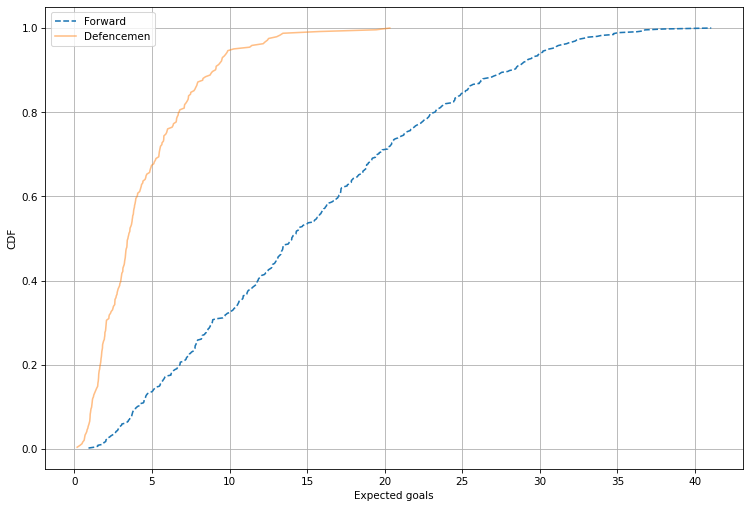

In [19]:
vals1 = df_goals[df_goals["position"]!="D"][feature].values
vals2 = df_goals[df_goals["position"]=="D"][feature].values

cdf_utils.plot_two_cdfs(vals1, vals2, name1="Forward", name2="Defencemen", xlabel="Expected goals")

## Step 8: Modeling Distributions

## Step 9: Probability Density Function and Kernel Density Estimate